In [33]:
# A/B Testing Analysis - Complete Step-by-Step Process
# Dataset: Website Background Color Testing (White vs Black)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("="*60)
print("A/B TESTING ANALYSIS - STEP BY STEP PROCESS")
print("="*60)


A/B TESTING ANALYSIS - STEP BY STEP PROCESS


In [26]:
# STEP 1: DATA LOADING AND INITIAL EXPLORATION
print("\nSTEP 1: DATA LOADING AND INITIAL EXPLORATION")
print("-" * 50)

# Load the actual dataset
df = pd.read_csv("ab_testing.csv")

# Clean column names (remove any extra spaces)
df.columns = df.columns.str.strip()

# Display column names to verify
print("Column names in dataset:")
print(df.columns.tolist())

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())



STEP 1: DATA LOADING AND INITIAL EXPLORATION
--------------------------------------------------
Column names in dataset:
['User ID', 'Group', 'Page Views', 'Time Spent', 'Conversion', 'Device', 'Location']
Dataset Shape: (5000, 7)

First 5 rows:
   User ID Group  Page Views  Time Spent Conversion   Device          Location
0    14292     B           3         424         No   Mobile  Northern Ireland
1    11682     A           9         342         No   Mobile          Scotland
2    19825     A           2         396         No  Desktop  Northern Ireland
3    16080     B           4         318         No  Desktop             Wales
4    18851     A           1         338        Yes  Desktop          Scotland

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User ID     5000 non-null   int64 
 1   Group       5000 non-null   objec

In [25]:
# STEP 2: DATA QUALITY CHECK
print("\n\nSTEP 2: DATA QUALITY CHECK")
print("-" * 50)

print("Missing values:")
print(df.isnull().sum())

print("\nDuplicate rows:", df.duplicated().sum())

print("\nGroup distribution:")
print(df['Group'].value_counts())
print(f"Group balance: {df['Group'].value_counts(normalize=True).round(3)}")



STEP 2: DATA QUALITY CHECK
--------------------------------------------------
Missing values:
User ID       0
Group         0
Page Views    0
Time Spent    0
Conversion    0
Device        0
Location      0
dtype: int64

Duplicate rows: 0

Group distribution:
Group
A    2519
B    2481
Name: count, dtype: int64
Group balance: Group
A    0.504
B    0.496
Name: proportion, dtype: float64




STEP 3: EXPLORATORY DATA ANALYSIS
--------------------------------------------------


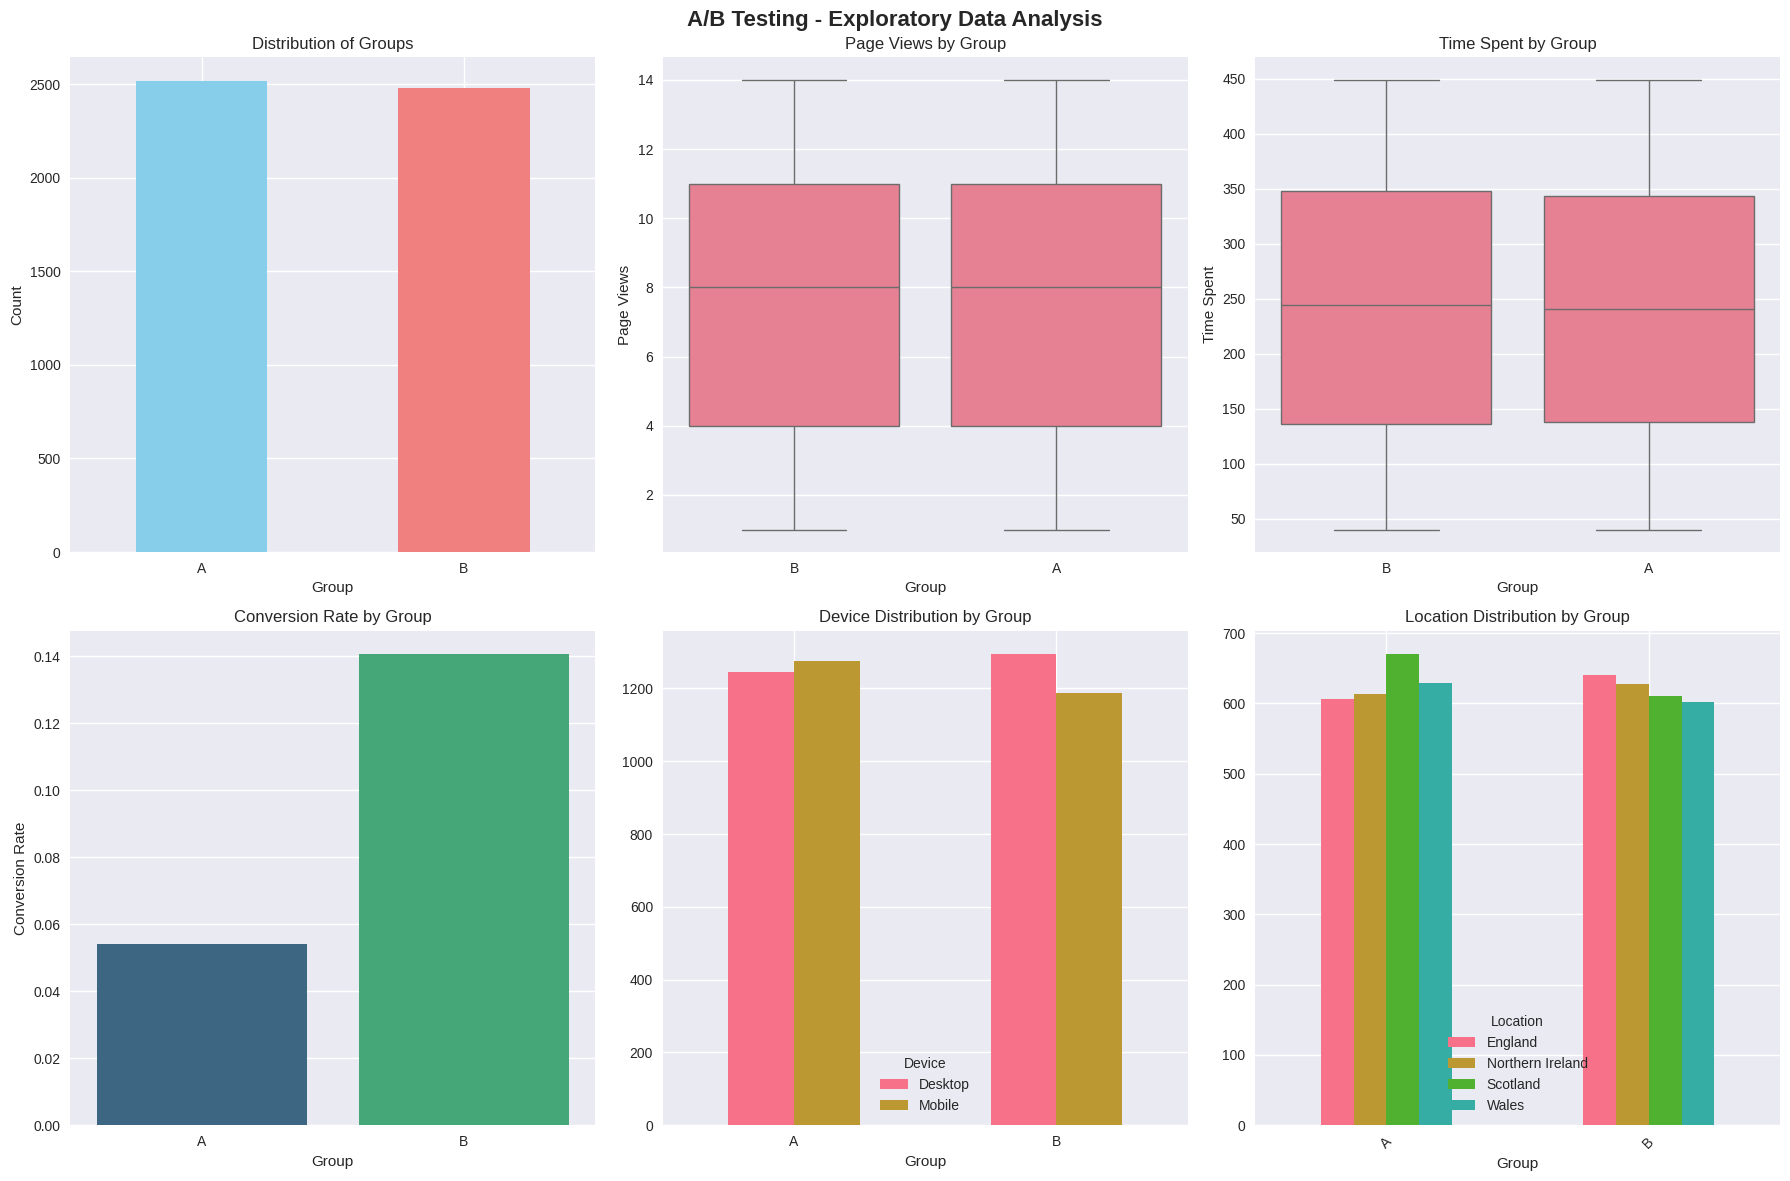

In [30]:
# STEP 3: EXPLORATORY DATA ANALYSIS (EDA)
print("\n\nSTEP 3: EXPLORATORY DATA ANALYSIS")
print("-" * 50)

# Create visualization function
def create_eda_plots(df):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('A/B Testing - Exploratory Data Analysis', fontsize=16, fontweight='bold')

    # 1. Group distribution
    df['Group'].value_counts().plot(kind='bar', ax=axes[0,0], color=['skyblue', 'lightcoral'])
    axes[0,0].set_title('Distribution of Groups')
    axes[0,0].set_ylabel('Count')
    axes[0,0].tick_params(axis='x', rotation=0)

    # 2. Page Views by Group
    sns.boxplot(data=df, x='Group', y='Page Views', ax=axes[0,1])
    axes[0,1].set_title('Page Views by Group')

    # 3. Time Spent by Group
    sns.boxplot(data=df, x='Group', y='Time Spent', ax=axes[0,2])
    axes[0,2].set_title('Time Spent by Group')

    # 4. Conversion Rate by Group
    conv_rate = df.groupby('Group')['Conversion'].apply(lambda x: (x=='Yes').mean()).reset_index()
    conv_rate.columns = ['Group', 'Conversion_Rate']
    sns.barplot(data=conv_rate, x='Group', y='Conversion_Rate', ax=axes[1,0], palette='viridis')
    axes[1,0].set_title('Conversion Rate by Group')
    axes[1,0].set_ylabel('Conversion Rate')

    # 5. Device distribution
    pd.crosstab(df['Group'], df['Device']).plot(kind='bar', ax=axes[1,1], stacked=False)
    axes[1,1].set_title('Device Distribution by Group')
    axes[1,1].tick_params(axis='x', rotation=0)

    # 6. Location distribution
    pd.crosstab(df['Group'], df['Location']).plot(kind='bar', ax=axes[1,2], stacked=False)
    axes[1,2].set_title('Location Distribution by Group')
    axes[1,2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

create_eda_plots(df)

In [23]:
# STEP 4: STATISTICAL ANALYSIS PREPARATION
print("\n\nSTEP 4: STATISTICAL ANALYSIS PREPARATION")
print("-" * 50)

# Separate groups
group_a = df[df['Group'] == 'A']
group_b = df[df['Group'] == 'B']

print(f"Group A size: {len(group_a)}")
print(f"Group B size: {len(group_b)}")

# Summary statistics by group
summary_stats = df.groupby('Group').agg({
    'Page Views': ['mean', 'std', 'median'],
    'Time Spent': ['mean', 'std', 'median'],
    'Conversion': lambda x: (x == 'Yes').mean()
}).round(3)

print("\nSummary Statistics by Group:")
print(summary_stats)



STEP 4: STATISTICAL ANALYSIS PREPARATION
--------------------------------------------------
Group A size: 2519
Group B size: 2481

Summary Statistics by Group:
      Page Views               Time Spent                 Conversion
            mean    std median       mean      std median   <lambda>
Group                                                               
A          7.582  4.080    8.0    241.733  117.340  241.0      0.054
B          7.493  3.963    8.0    243.304  119.194  244.0      0.141


In [22]:
# STEP 5: HYPOTHESIS TESTING
print("\n\nSTEP 5: HYPOTHESIS TESTING")
print("-" * 50)

def perform_hypothesis_tests(df):
    results = {}

    # 1. Conversion Rate Test (Chi-square test)
    print("1. CONVERSION RATE TEST")
    print("-" * 30)

    # Create contingency table
    contingency_table = pd.crosstab(df['Group'], df['Conversion'])
    print("Contingency Table:")
    print(contingency_table)

    # Perform chi-square test
    chi2, p_value_conv, dof, expected = chi2_contingency(contingency_table)

    # Calculate conversion rates
    conv_rate_a = (group_a['Conversion'] == 'Yes').mean()
    conv_rate_b = (group_b['Conversion'] == 'Yes').mean()

    print(f"\nConversion Rate A: {conv_rate_a:.3f} ({conv_rate_a*100:.1f}%)")
    print(f"Conversion Rate B: {conv_rate_b:.3f} ({conv_rate_b*100:.1f}%)")
    print(f"Difference: {conv_rate_b - conv_rate_a:.3f} ({((conv_rate_b - conv_rate_a)*100):.1f} percentage points)")
    print(f"Relative Improvement: {((conv_rate_b/conv_rate_a - 1)*100):.1f}%")
    print(f"Chi-square statistic: {chi2:.3f}")
    print(f"P-value: {p_value_conv:.4f}")
    print(f"Significant at α=0.05: {'Yes' if p_value_conv < 0.05 else 'No'}")

    results['conversion'] = {
        'rate_a': conv_rate_a,
        'rate_b': conv_rate_b,
        'p_value': p_value_conv,
        'significant': p_value_conv < 0.05
    }

    # 2. Page Views Test (T-test)
    print("\n\n2. PAGE VIEWS TEST")
    print("-" * 30)

    # Check normality (Shapiro-Wilk test on samples)
    sample_a = group_a['Page Views'].sample(min(5000, len(group_a)))
    sample_b = group_b['Page Views'].sample(min(5000, len(group_b)))

    # Perform t-test
    t_stat_pv, p_value_pv = ttest_ind(group_a['Page Views'], group_b['Page Views'])

    mean_pv_a = group_a['Page Views'].mean()
    mean_pv_b = group_b['Page Views'].mean()

    print(f"Mean Page Views A: {mean_pv_a:.2f}")
    print(f"Mean Page Views B: {mean_pv_b:.2f}")
    print(f"Difference: {mean_pv_b - mean_pv_a:.2f}")
    print(f"T-statistic: {t_stat_pv:.3f}")
    print(f"P-value: {p_value_pv:.4f}")
    print(f"Significant at α=0.05: {'Yes' if p_value_pv < 0.05 else 'No'}")

    results['page_views'] = {
        'mean_a': mean_pv_a,
        'mean_b': mean_pv_b,
        'p_value': p_value_pv,
        'significant': p_value_pv < 0.05
    }

    # 3. Time Spent Test (Mann-Whitney U test - non-parametric)
    print("\n\n3. TIME SPENT TEST")
    print("-" * 30)

    # Mann-Whitney U test (non-parametric alternative to t-test)
    u_stat, p_value_ts = mannwhitneyu(group_a['Time Spent'], group_b['Time Spent'], alternative='two-sided')

    mean_ts_a = group_a['Time Spent'].mean()
    mean_ts_b = group_b['Time Spent'].mean()
    median_ts_a = group_a['Time Spent'].median()
    median_ts_b = group_b['Time Spent'].median()

    print(f"Mean Time Spent A: {mean_ts_a:.1f} seconds")
    print(f"Mean Time Spent B: {mean_ts_b:.1f} seconds")
    print(f"Median Time Spent A: {median_ts_a:.1f} seconds")
    print(f"Median Time Spent B: {median_ts_b:.1f} seconds")
    print(f"Difference in means: {mean_ts_b - mean_ts_a:.1f} seconds")
    print(f"U-statistic: {u_stat:.0f}")
    print(f"P-value: {p_value_ts:.4f}")
    print(f"Significant at α=0.05: {'Yes' if p_value_ts < 0.05 else 'No'}")

    results['time_spent'] = {
        'mean_a': mean_ts_a,
        'mean_b': mean_ts_b,
        'p_value': p_value_ts,
        'significant': p_value_ts < 0.05
    }

    return results

test_results = perform_hypothesis_tests(df)



STEP 5: HYPOTHESIS TESTING
--------------------------------------------------
1. CONVERSION RATE TEST
------------------------------
Contingency Table:
Conversion    No  Yes
Group                
A           2383  136
B           2132  349

Conversion Rate A: 0.054 (5.4%)
Conversion Rate B: 0.141 (14.1%)
Difference: 0.087 (8.7 percentage points)
Relative Improvement: 160.5%
Chi-square statistic: 106.228
P-value: 0.0000
Significant at α=0.05: Yes


2. PAGE VIEWS TEST
------------------------------
Mean Page Views A: 7.58
Mean Page Views B: 7.49
Difference: -0.09
T-statistic: 0.779
P-value: 0.4360
Significant at α=0.05: No


3. TIME SPENT TEST
------------------------------
Mean Time Spent A: 241.7 seconds
Mean Time Spent B: 243.3 seconds
Median Time Spent A: 241.0 seconds
Median Time Spent B: 244.0 seconds
Difference in means: 1.6 seconds
U-statistic: 3101095
P-value: 0.6420
Significant at α=0.05: No


In [21]:
# STEP 6: EFFECT SIZE CALCULATION
print("\n\nSTEP 6: EFFECT SIZE CALCULATION")
print("-" * 50)

def calculate_effect_sizes(df, test_results):
    print("Effect Sizes:")

    # Cohen's d for Page Views
    pooled_std_pv = np.sqrt(((len(group_a)-1)*group_a['Page Views'].var() +
                            (len(group_b)-1)*group_b['Page Views'].var()) /
                           (len(group_a) + len(group_b) - 2))
    cohens_d_pv = (test_results['page_views']['mean_b'] - test_results['page_views']['mean_a']) / pooled_std_pv

    print(f"Cohen's d for Page Views: {cohens_d_pv:.3f}")
    print(f"Effect size interpretation: {interpret_cohens_d(cohens_d_pv)}")

    # Cohen's d for Time Spent
    pooled_std_ts = np.sqrt(((len(group_a)-1)*group_a['Time Spent'].var() +
                            (len(group_b)-1)*group_b['Time Spent'].var()) /
                           (len(group_a) + len(group_b) - 2))
    cohens_d_ts = (test_results['time_spent']['mean_b'] - test_results['time_spent']['mean_a']) / pooled_std_ts

    print(f"Cohen's d for Time Spent: {cohens_d_ts:.3f}")
    print(f"Effect size interpretation: {interpret_cohens_d(cohens_d_ts)}")

    # Odds ratio for Conversion
    conv_table = pd.crosstab(df['Group'], df['Conversion'])
    odds_a = conv_table.loc['A', 'Yes'] / conv_table.loc['A', 'No']
    odds_b = conv_table.loc['B', 'Yes'] / conv_table.loc['B', 'No']
    odds_ratio = odds_b / odds_a

    print(f"Odds Ratio for Conversion: {odds_ratio:.3f}")
    print(f"Interpretation: Group B is {odds_ratio:.2f}x more likely to convert than Group A")

def interpret_cohens_d(d):
    d = abs(d)
    if d < 0.2:
        return "Small effect"
    elif d < 0.5:
        return "Small to medium effect"
    elif d < 0.8:
        return "Medium to large effect"
    else:
        return "Large effect"

calculate_effect_sizes(df, test_results)



STEP 6: EFFECT SIZE CALCULATION
--------------------------------------------------
Effect Sizes:
Cohen's d for Page Views: -0.022
Effect size interpretation: Small effect
Cohen's d for Time Spent: 0.013
Effect size interpretation: Small effect
Odds Ratio for Conversion: 2.868
Interpretation: Group B is 2.87x more likely to convert than Group A


In [20]:
# STEP 7: SEGMENT ANALYSIS
print("\n\nSTEP 7: SEGMENT ANALYSIS")
print("-" * 50)

def segment_analysis(df):
    print("Analysis by Device Type:")
    device_analysis = df.groupby(['Device', 'Group']).agg({
        'Conversion': lambda x: (x == 'Yes').mean(),
        'Page Views': 'mean',
        'Time Spent': 'mean'
    }).round(3)
    print(device_analysis)

    print("\nAnalysis by Location:")
    location_analysis = df.groupby(['Location', 'Group']).agg({
        'Conversion': lambda x: (x == 'Yes').mean(),
        'Page Views': 'mean',
        'Time Spent': 'mean'
    }).round(3)
    print(location_analysis)

segment_analysis(df)



STEP 7: SEGMENT ANALYSIS
--------------------------------------------------
Analysis by Device Type:
               Conversion  Page Views  Time Spent
Device  Group                                    
Desktop A           0.059       7.519     243.131
        B           0.139       7.541     243.238
Mobile  A           0.049       7.642     240.369
        B           0.142       7.441     243.376

Analysis by Location:
                        Conversion  Page Views  Time Spent
Location         Group                                    
England          A           0.069       7.591     241.713
                 B           0.147       7.633     249.858
Northern Ireland A           0.050       7.648     238.661
                 B           0.115       7.326     247.559
Scotland         A           0.049       7.633     237.970
                 B           0.151       7.530     230.236
Wales            A           0.048       7.453     248.760
                 B           0.151       7.

In [19]:
# STEP 8: STATISTICAL POWER ANALYSIS
print("\n\nSTEP 8: STATISTICAL POWER ANALYSIS")
print("-" * 50)

def power_analysis():
    # Manual power calculation for conversion rate
    n1, n2 = len(group_a), len(group_b)
    p1 = test_results['conversion']['rate_a']
    p2 = test_results['conversion']['rate_b']

    # Effect size (Cohen's h for proportions)
    h = 2 * (np.arcsin(np.sqrt(p2)) - np.arcsin(np.sqrt(p1)))

    print(f"Sample sizes: Group A = {n1}, Group B = {n2}")
    print(f"Effect size (Cohen's h): {h:.3f}")
    print(f"Observed conversion rates: A = {p1:.3f}, B = {p2:.3f}")

    # Simplified power calculation using normal approximation
    # Standard error for difference in proportions
    p_pooled = (p1 * n1 + p2 * n2) / (n1 + n2)
    se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n1 + 1/n2))

    # Effect size in terms of difference
    effect = abs(p2 - p1)

    # Calculate z-score for the observed effect
    z_score = effect / se

    # Approximate power calculation
    alpha = 0.05
    z_alpha = stats.norm.ppf(1 - alpha/2)  # Critical value for two-tailed test

    # Power approximation using normal distribution
    power_approx = 1 - stats.norm.cdf(z_alpha - z_score) + stats.norm.cdf(-z_alpha - z_score)

    print(f"Approximate statistical power: {power_approx:.3f} ({power_approx*100:.1f}%)")

    # Alternative: Minimum detectable effect
    mde = z_alpha * se
    print(f"Minimum detectable effect: {mde:.3f} ({mde*100:.1f} percentage points)")

    if power_approx < 0.8:
        print("⚠️  Statistical power appears to be below recommended 80%")
        # Calculate required sample size for 80% power
        z_beta = stats.norm.ppf(0.8)  # 80% power
        n_required = 2 * ((z_alpha + z_beta) * np.sqrt(p_pooled * (1 - p_pooled)) / effect) ** 2
        print(f"💡 Suggested sample size for 80% power: ~{int(n_required)} per group")
    else:
        print("✅ Statistical power appears adequate (≥80%)")

    # Additional insights
    print(f"\nSample Size Assessment:")
    print(f"- Current total sample size: {n1 + n2}")
    print(f"- Effect size magnitude: {'Small' if abs(h) < 0.2 else 'Medium' if abs(h) < 0.5 else 'Large'}")
    print(f"- Statistical significance: {'Yes' if test_results['conversion']['significant'] else 'No'}")

power_analysis()



STEP 8: STATISTICAL POWER ANALYSIS
--------------------------------------------------
Sample sizes: Group A = 2519, Group B = 2481
Effect size (Cohen's h): 0.300
Observed conversion rates: A = 0.054, B = 0.141
Approximate statistical power: 1.000 (100.0%)
Minimum detectable effect: 0.016 (1.6 percentage points)
✅ Statistical power appears adequate (≥80%)

Sample Size Assessment:
- Current total sample size: 5000
- Effect size magnitude: Medium
- Statistical significance: Yes


In [18]:
# STEP 9: FINAL RECOMMENDATIONS
print("\n\n" + "="*60)
print("STEP 9: FINAL RECOMMENDATIONS AND CONCLUSIONS")
print("="*60)

def generate_recommendations(test_results):
    print("SUMMARY OF RESULTS:")
    print("-" * 20)

    significant_tests = []

    for metric, results in test_results.items():
        status = "✅ Significant" if results['significant'] else "❌ Not Significant"
        print(f"{metric.replace('_', ' ').title()}: {status} (p-value: {results['p_value']:.4f})")
        if results['significant']:
            significant_tests.append(metric)

    print(f"\nNumber of significant results: {len(significant_tests)}/3")

    print("\nRECOMMendations:")
    print("-" * 15)

    if test_results['conversion']['significant']:
        improvement = ((test_results['conversion']['rate_b'] / test_results['conversion']['rate_a'] - 1) * 100)
        print(f"🎯 IMPLEMENT GROUP B: Conversion rate improved by {improvement:.1f}%")
        print(f"   - Group A conversion: {test_results['conversion']['rate_a']:.1%}")
        print(f"   - Group B conversion: {test_results['conversion']['rate_b']:.1%}")
    else:
        print("🤔 NO CLEAR WINNER: Conversion rates are not significantly different")

    if len(significant_tests) >= 2:
        print("✅ STRONG RECOMMENDATION: Multiple metrics show significant improvement")
    elif len(significant_tests) == 1:
        print("⚠️  MODERATE RECOMMENDATION: Only one metric shows significant improvement")
    else:
        print("❌ NO RECOMMENDATION: No significant improvements detected")

    print("\nNEXT STEPS:")
    print("- Consider running the test for a longer period if inconclusive")
    print("- Analyze segment-specific results for targeted implementations")
    print("- Monitor long-term effects if implementing changes")
    print("- Consider business significance alongside statistical significance")

generate_recommendations(test_results)

print("\n" + "="*60)
print("A/B TESTING ANALYSIS COMPLETE")
print("="*60)



STEP 9: FINAL RECOMMENDATIONS AND CONCLUSIONS
SUMMARY OF RESULTS:
--------------------
Conversion: ✅ Significant (p-value: 0.0000)
Page Views: ❌ Not Significant (p-value: 0.4360)
Time Spent: ❌ Not Significant (p-value: 0.6420)

Number of significant results: 1/3

RECOMMendations:
---------------
🎯 IMPLEMENT GROUP B: Conversion rate improved by 160.5%
   - Group A conversion: 5.4%
   - Group B conversion: 14.1%
⚠️  MODERATE RECOMMENDATION: Only one metric shows significant improvement

NEXT STEPS:
- Consider running the test for a longer period if inconclusive
- Analyze segment-specific results for targeted implementations
- Monitor long-term effects if implementing changes
- Consider business significance alongside statistical significance

A/B TESTING ANALYSIS COMPLETE
